# Contents

### 1. Prepare for analysis 
#### Import packages and set working directory
#### Read in and pre-process data


### 2. Feature selection (unsupervised)

### 3. Clustering
#### 3A. MeanShift (density-based) clustering
#### 3B. Hierarchical (agglomerative) clustering


### 4. Dimensionality reduction (feature extraction) using UMAP


### 5. Visualization
#### 5.1 Cluster heatmap

## 1 - Prepare for analysis

### 1.1 - Import Packages

In [1]:
import os  # <- package used to work with system filepaths
import pandas as pd  # <- package used to import and organize data
import numpy as np  # <- package used to import and organize data
import math
import seaborn as sns  # <- package used to plot graphs
from matplotlib import pyplot as plt  # <- another package used to plot graphs
from itertools import cycle  # <- package used to iterate down rows
from ipywidgets import widgets  # <- widget tool to generate button
from IPython.display import display  # <- displays button
from tkinter import Tk, filedialog  # <- Tkinter is a GUI package
from tqdm.notebook import tqdm
import pingouin as pg
from pingouin import ttest
import scipy
from scipy.stats import ttest_ind
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

# Dimension reduction and clustering libraries
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import umap

pd.set_option('display.max_columns', 50)
print("done step 1")

C:\Users\chris\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


done step 1


In [2]:
import sys
!{sys.executable} -m pip install umap-learn

### 1.2 - Set working directory to where the CSV file with experiment data is

In [3]:
os.getcwd()
os.chdir('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data')

### 1.3 - Read in and pre-process data


## 2 - Feature Selection (unsupervised)

### 2A - Generate Spearman correlation matrix of all phenotype and neuron gene expression variables

##### Spearman correlations are calculated based on the rank order of variables and are more robust to violations of normality. Heavy tails and outliers have a strong impact on the Pearson correlation, but these effects are virtually non-existent with Spearman. Useful for non-linear monotonic relationships.

In [34]:
df = pd.read_csv('MergedDARelatedNeurons_MinMaxScaler_df.csv')
df.set_index('Genotype', inplace=True)

from scipy.stats import spearmanr 

# Compute Spearman correlation matrix
MergedDARelatedNeurons_spearman_corr_matrix = MergedDARelatedNeurons_scaled_df.corr(method='spearman')

print(MergedDARelatedNeurons_spearman_corr_matrix.shape)
print("Spearman Correlation Matrix:\n", MergedDARelatedNeurons_spearman_corr_matrix)

(87, 87)
Spearman Correlation Matrix:
                    length   midline     width  morphwidth      area  \
length           1.000000  0.962406  0.380451    0.619549  0.909774   
midline          0.962406  1.000000  0.533835    0.694737  0.948872   
width            0.380451  0.533835  1.000000    0.673684  0.613534   
morphwidth       0.619549  0.694737  0.673684    1.000000  0.854135   
area             0.909774  0.948872  0.613534    0.854135  1.000000   
...                   ...       ...       ...         ...       ...   
VA12_exp_level   0.395345  0.459380  0.442675    0.668189  0.564249   
VB_exp_level     0.072331  0.195215  0.390429    0.212325  0.209214   
VB01_exp_level   0.266869  0.345271  0.427442    0.339240  0.343009   
VB02_exp_level   0.303579  0.396234  0.435406    0.325424  0.380415   
VD_DD_exp_level -0.258674 -0.184013 -0.094269   -0.079940 -0.141780   

                 speed_OffFood  angularspeed_OffFood  bias_OffFood  \
length                0.550376        

#### Visual representation of correlation matrix Using Matplotlib and Seaborn

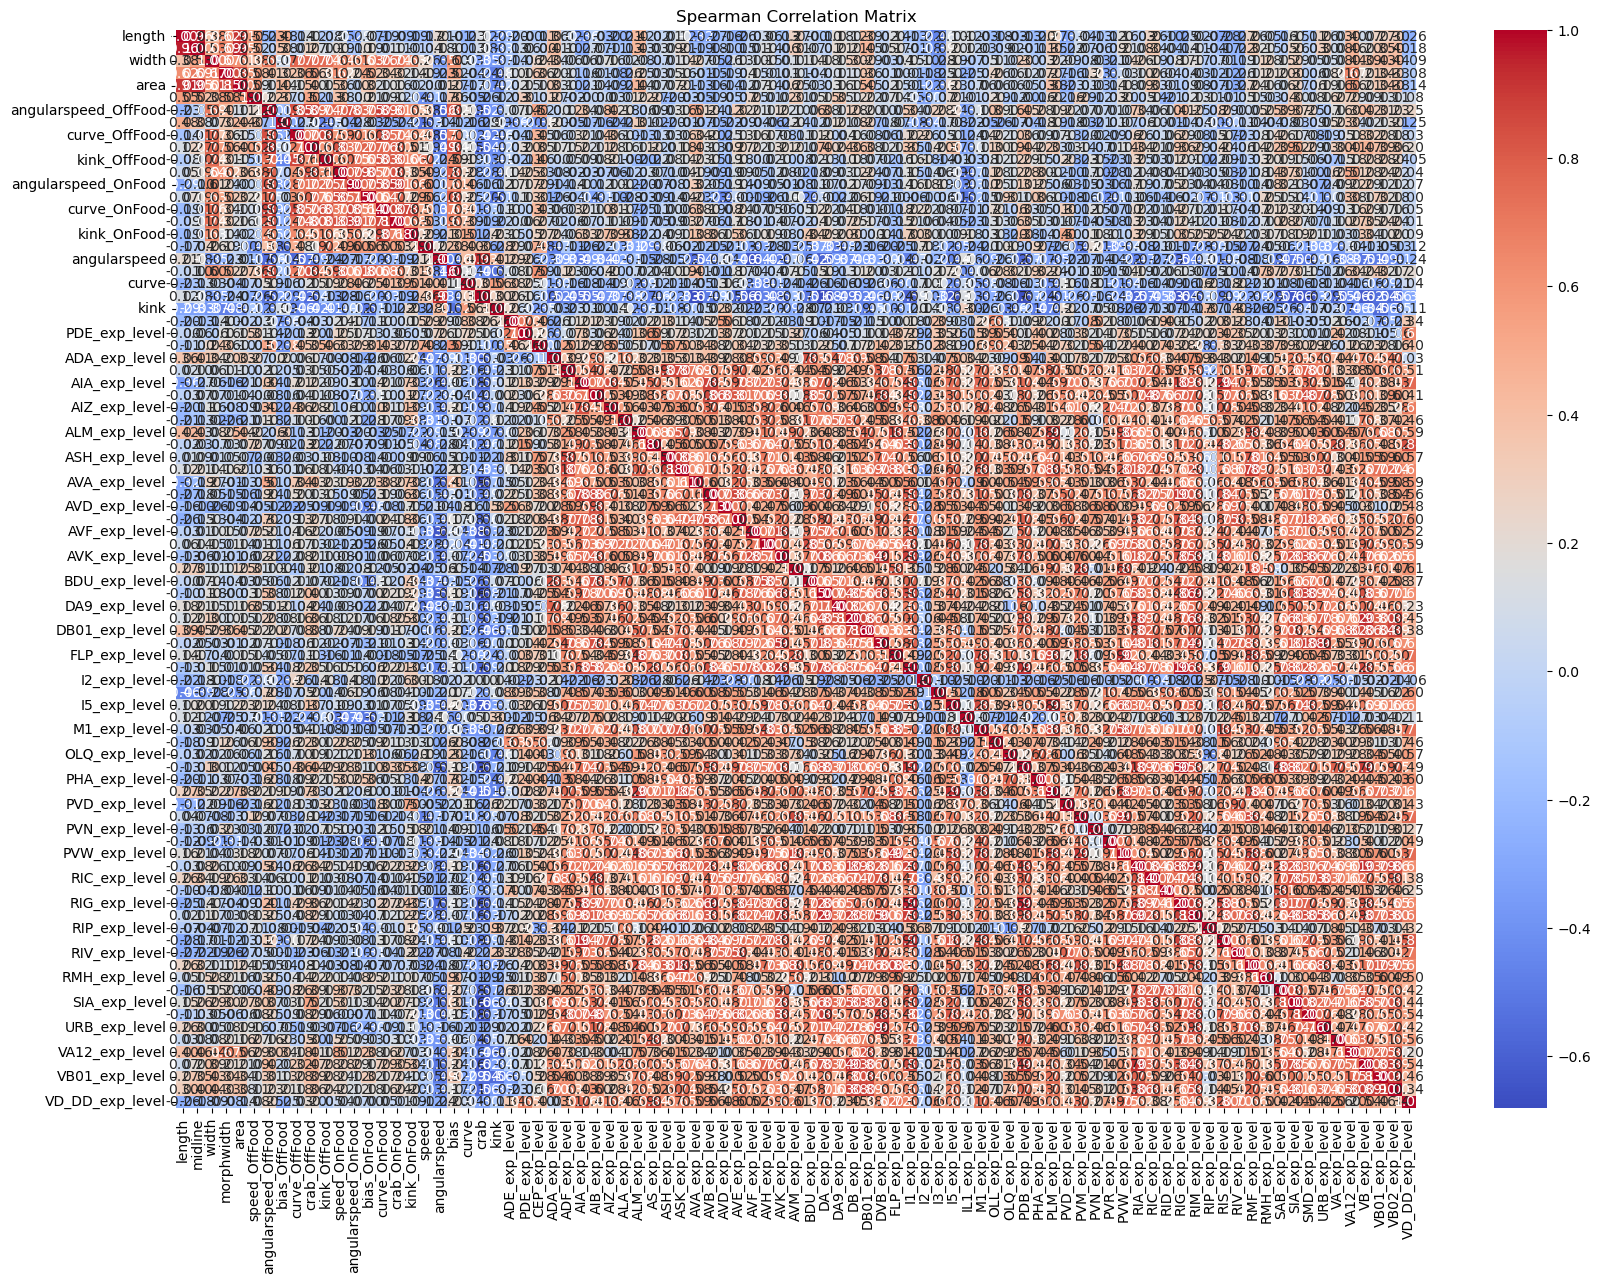

In [35]:
plt.figure(figsize=(20, 14))
sns.heatmap(MergedDARelatedNeurons_spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix')
plt.savefig('MergedDARelatedNeurons_spearman_corr_matrix.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

### 2B - Perform feature selection based on generated Spearman correlation matrix

1. **Identify Highly Correlated Features**: Examine the Spearman correlation matrix to find pairs of features with high absolute correlation coefficients.

2. **Select Features**: Decide on a threshold for the correlation coefficient above which features are considered highly correlated. You may choose to keep one feature from each highly correlated pair or remove both.

3. **Remove Highly Correlated Features**: Once you have identified highly correlated features, remove them from your dataset.

4. **Remove features below a certain variance threshold across all genes**

#### Identify pairs of features with a correlation coefficient above a specified threshold (i.e., highly-correlated feature pairs), and remove one feature from each highly-correlated pair to reduce redundancy

In [36]:
# Define a threshold for filtering
threshold = 0.8 # will filter out one feature per pair with Spearman's r > 0.8

# Create a boolean mask to identify which pairs are above the threshold
high_corr_pairs = np.abs(MergedDARelatedNeurons_spearman_corr_matrix) > threshold

# Create a set to hold the columns to drop
columns_to_drop = set()

# Iterate through the correlation matrix
for i in range(len(high_corr_pairs.columns)):
    for j in range(i):
        if high_corr_pairs.iloc[i, j] and i != j:
            colname = high_corr_pairs.columns[i]
            columns_to_drop.add(colname)

# Drop the columns identified
MergedDARelatedNeurons_scaled_CorrelationFiltered_df = MergedDARelatedNeurons_scaled_df.drop(columns=columns_to_drop)

# Save the filtered DataFrame to a new CSV
MergedDARelatedNeurons_scaled_CorrelationFiltered_df.to_csv('MergedDARelatedNeurons_scaled_CorrelationFiltered_df.csv')

print("Original shape:", MergedDARelatedNeurons_scaled_df.shape)
print("Filtered shape:", MergedDARelatedNeurons_scaled_CorrelationFiltered_df.shape)
print(MergedDARelatedNeurons_scaled_CorrelationFiltered_df)


Original shape: (20, 87)
Filtered shape: (20, 37)
                     length     width  morphwidth  speed_OffFood  \
Genotype                                                           
cat-2(e1112)       0.718449  2.375258    1.904257       1.854562   
catp-7(tm4438)     0.574900  0.133460   -0.247274       0.725809   
catp-7(tm8556)     0.501955  0.057399   -0.770286       0.376775   
cpr-4(ok3413)     -1.043421  0.178374   -0.561902      -1.265516   
cpr-5(ok2344)     -1.987510  0.602425   -0.311877      -0.698029   
cpr-6(tm12210)     0.490864  0.206908    0.297867       1.223103   
cpr-8(ok2956)     -1.137524 -1.245215   -1.531125      -1.551450   
djr-1.1(tm918)    -1.296926 -1.824455   -2.192671      -0.190963   
djr-1.2(tm817)    -0.007005 -0.849725   -0.199547      -0.263194   
djr-1.2(tm951)     0.252147 -1.686454   -0.700889       0.630496   
exp-2(sa26ad1426) -0.005512  0.837575    1.317394      -0.531920   
kvs-5(tm6152)      0.011803 -0.257301   -0.255489      -1.250808  

#### Removing features with low variance (i.e., no variance across most features) 
##### use after MinMaxScaler or MaxAbsScaler, NOT StandardScaler (as StandardScaler causes all features to have unit variance = 1)

In [39]:
from sklearn.feature_selection import VarianceThreshold

data = pd.read_csv('MergedDARelatedNeurons_scaled_CorrelationFiltered_df.csv')
data.set_index('Genotype', inplace=True)

# Apply Variance Threshold
sel = VarianceThreshold(threshold=(.9 * (1 - .9))) # Removes features with zero variance in 90% of the genotypes
VarianceThreshold_filtered_data = sel.fit_transform(data)

# Create a new DataFrame with the selected features
selected_columns = data.columns[sel.get_support()]
MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df = pd.DataFrame(data=VarianceThreshold_filtered_data, columns=selected_columns, index=data.index)

# Save the merged DataFrame as a CSV file to a specific directory
MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.to_csv('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data\\MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.csv', index=True)

# Print the resulting DataFrame shape and contents
print(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.shape)
print(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df)

# print(MergedDARelatedNeurons_MinMaxScaler_df.shape)
# print(MergedDARelatedNeurons_MinMaxScaler_df)

(20, 37)
                     length     width  morphwidth  speed_OffFood  \
Genotype                                                           
cat-2(e1112)       0.718449  2.375258    1.904257       1.854562   
catp-7(tm4438)     0.574900  0.133460   -0.247274       0.725809   
catp-7(tm8556)     0.501955  0.057399   -0.770286       0.376775   
cpr-4(ok3413)     -1.043421  0.178374   -0.561902      -1.265516   
cpr-5(ok2344)     -1.987510  0.602425   -0.311877      -0.698029   
cpr-6(tm12210)     0.490864  0.206908    0.297867       1.223103   
cpr-8(ok2956)     -1.137524 -1.245215   -1.531125      -1.551450   
djr-1.1(tm918)    -1.296926 -1.824455   -2.192671      -0.190963   
djr-1.2(tm817)    -0.007005 -0.849725   -0.199547      -0.263194   
djr-1.2(tm951)     0.252147 -1.686454   -0.700889       0.630496   
exp-2(sa26ad1426) -0.005512  0.837575    1.317394      -0.531920   
kvs-5(tm6152)      0.011803 -0.257301   -0.255489      -1.250808   
lfe-2(sy326)      -0.902923 -0.837892  

## 3 - Clustering

### 3A - MeanShift clustering

In [ ]:
from sklearn.cluster import MeanShift

# Instantiate MeanShift clustering
meanshift = MeanShift()

# Fit MeanShift clustering to the UMAP-transformed data
meanshift.fit(clusterable_embedding)

# Get the labels assigned by MeanShift clustering
cluster_labels = meanshift.labels_
cluster_centers = meanshift.cluster_centers_

cluster_labels_unique = np.unique(cluster_labels)
n_clusters_ = len(cluster_labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Add the genotype information back to the data points
ClusteredMergedDopaminergicNeurons_scaled_df = MergedDopaminergicNeurons_scaled_df.copy()
ClusteredMergedDopaminergicNeurons_scaled_df['Cluster'] = cluster_labels
ClusteredMergedDopaminergicNeurons_scaled_df = ClusteredMergedDopaminergicNeurons_scaled_df.sort_values(by='Cluster')

ClusteredMergedDopaminergicNeurons_scaled_df.to_csv('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data\\ClusteredMergedDopaminergicNeurons_scaled_df.csv', index=True)
print(ClusteredMergedDopaminergicNeurons_scaled_df)
# Now data_with_genotype contains the genotype column along with the cluster labels assigned by MeanShift clustering

In [ ]:
from sklearn.cluster import MeanShift

# Instantiate MeanShift clustering
meanshift1 = MeanShift()

# Fit MeanShift clustering to the UMAP-transformed data
meanshift1.fit(clusterable_embedding1)

# Get the labels assigned by MeanShift clustering
cluster_labels1 = meanshift1.labels_
cluster_centers1 = meanshift1.cluster_centers_

cluster_labels1_unique = np.unique(cluster_labels1)
n_clusters1_ = len(cluster_labels1_unique)

print("number of estimated clusters : %d" % n_clusters1_)

# Add the genotype information back to the data points
ClusteredMergedDAReceptorNeurons_scaled_df = MergedDAReceptorNeurons_scaled_df.copy()
ClusteredMergedDAReceptorNeurons_scaled_df['Cluster'] = cluster_labels1
ClusteredMergedDAReceptorNeurons_scaled_df = ClusteredMergedDAReceptorNeurons_scaled_df.sort_values(by='Cluster')

ClusteredMergedDAReceptorNeurons_scaled_df.to_csv('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data\\ClusteredMergedDAReceptorNeurons_scaled_df.csv', index=True)
print(ClusteredMergedDAReceptorNeurons_scaled_df)
# Now data_with_genotype contains the genotype column along with the cluster labels assigned by MeanShift clustering

#### MeanShift clustering (pre-UMAP) for DA-Related Neurons

In [58]:
from sklearn.cluster import MeanShift

# Instantiate MeanShift clustering
meanshift2 = MeanShift()

# Fit MeanShift clustering to the transformed data
meanshift2.fit(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df)

# Get the labels assigned by MeanShift clustering
cluster_labels2 = meanshift2.labels_
cluster_centers2 = meanshift2.cluster_centers_

cluster_labels2_unique = np.unique(cluster_labels2)
n_clusters2_ = len(cluster_labels2_unique)

print("number of estimated clusters : %d" % n_clusters2_)

# Add the genotype information back to the data points
ClusteredMergedDARelatedNeurons_df = MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.copy()
ClusteredMergedDARelatedNeurons_df['Cluster'] = cluster_labels2
ClusteredMergedDARelatedNeurons_df = ClusteredMergedDARelatedNeurons_df.sort_values(by='Cluster')

ClusteredMergedDARelatedNeurons_df.to_csv('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data\\ClusteredMergedDARelatedNeurons_df.csv', index=True)
print(ClusteredMergedDARelatedNeurons_df)
# Now data_with_genotype contains the genotype column along with the cluster labels assigned by MeanShift clustering

number of estimated clusters : 5
                     length     width  morphwidth  speed_OffFood  \
Genotype                                                           
djr-1.2(tm951)     0.252147 -1.686454   -0.700889       0.630496   
catp-7(tm4438)     0.574900  0.133460   -0.247274       0.725809   
catp-7(tm8556)     0.501955  0.057399   -0.770286       0.376775   
cpr-4(ok3413)     -1.043421  0.178374   -0.561902      -1.265516   
cpr-5(ok2344)     -1.987510  0.602425   -0.311877      -0.698029   
cpr-6(tm12210)     0.490864  0.206908    0.297867       1.223103   
cpr-8(ok2956)     -1.137524 -1.245215   -1.531125      -1.551450   
djr-1.1(tm918)    -1.296926 -1.824455   -2.192671      -0.190963   
djr-1.2(tm817)    -0.007005 -0.849725   -0.199547      -0.263194   
rme-8(b1023)      -1.530646 -0.078402   -0.955913      -1.910449   
ncs-7(tm5037)      1.064180  0.865958    0.939107       1.307165   
ncs-7(tm4648)      1.658877 -0.234523    0.511519      -0.056646   
lfe-2(sy326)   

### MeanShift clustering visualization

<IPython.core.display.Javascript object>


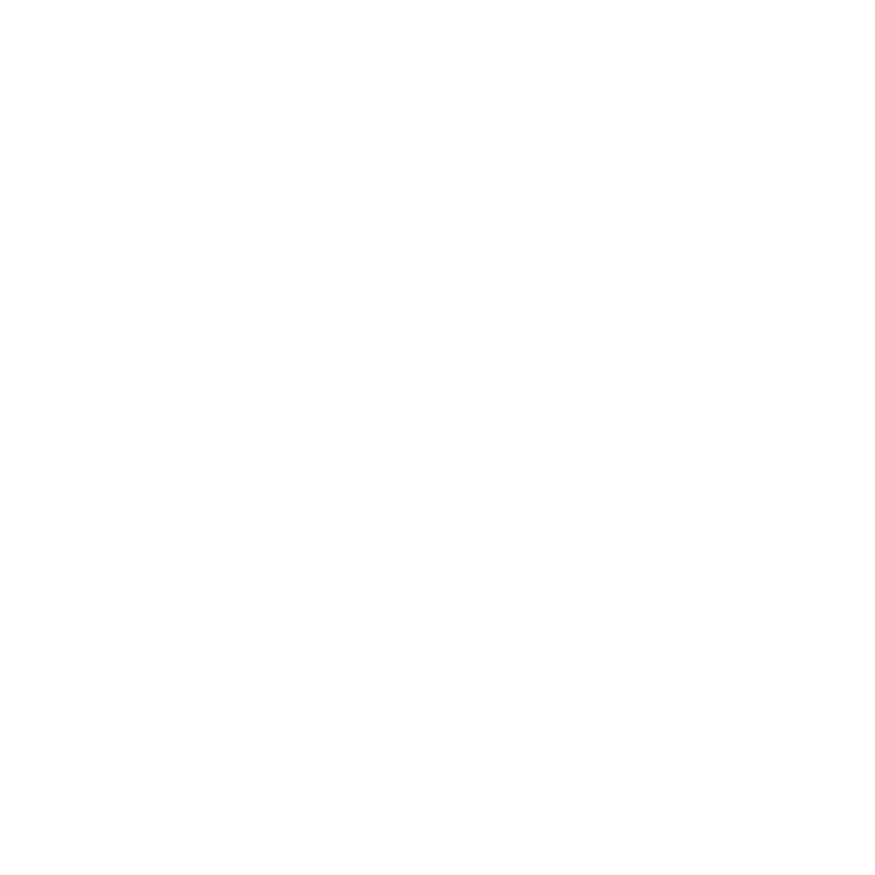

NameError: name 'n_clusters_' is not defined

In [62]:
plt.figure(figsize=(7, 7))

colors = ["#FF8C00", "#006400", "#FF1493"]
markers = ["o", "o", "o"]

for k, col in zip(range(n_clusters_), colors):
    my_members = cluster_labels == k
    cluster_center = cluster_centers[k]
    plt.plot(clusterable_embedding[my_members, 0], clusterable_embedding[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=10,
    )
plt.title("MeanShift (Density-Based) Clustering of Genotypes \nby Phenotype Measures and Dopaminergic Neuron Gene Expression Levels \n")
plt.text(-2.7, 8.63, '(Estimated number of clusters: %d)' % n_clusters_, fontsize=10, color='black', ha='center', weight="bold")
plt.savefig('MergedDopaminergicNeurons_meanshiftclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")

plt.show()

<IPython.core.display.Javascript object>


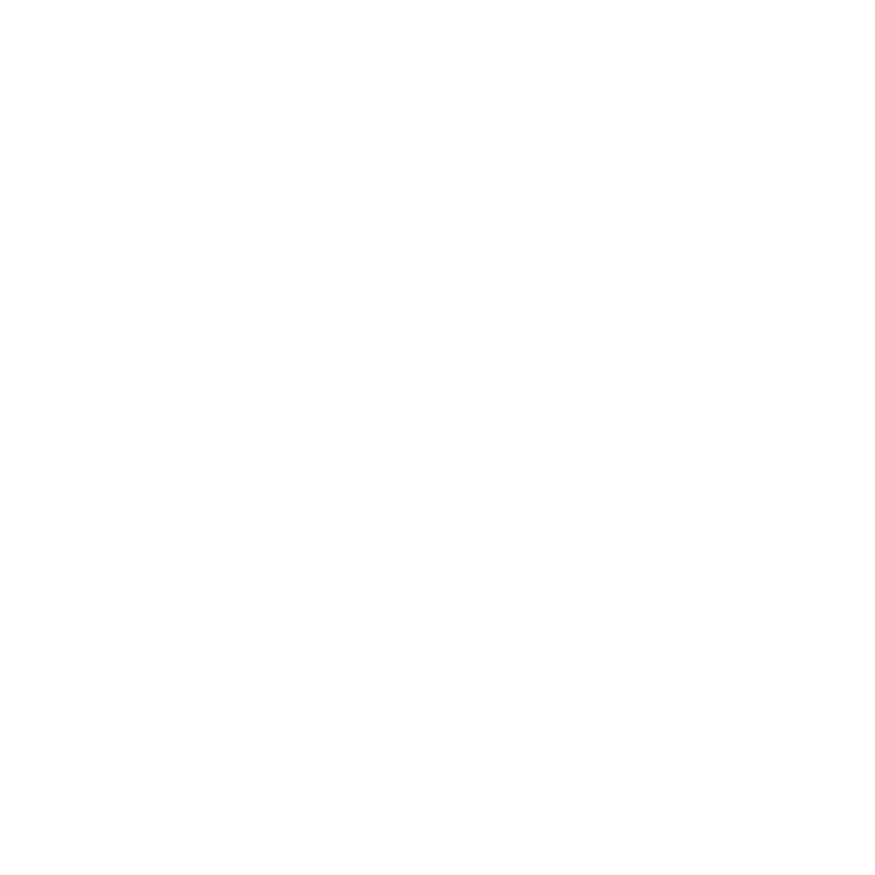

NameError: name 'clusterable_embedding2' is not defined

In [60]:
plt.figure(figsize=(7, 7))

colors = ["#FF8C00", "#006400", "#FF1493", "#4169E1"]
markers = ["o", "o", "o", "o"]

for k, col in zip(range(n_clusters1_), colors):
    my_members = cluster_labels1 == k
    cluster_center1 = cluster_centers1[k]
    plt.plot(clusterable_embedding1[my_members, 0], clusterable_embedding1[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center1[0],
        cluster_center1[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=10,
    )
plt.title("MeanShift (Density-Based) Clustering of Genotypes by \nPhenotype Measures and DA Receptor-Expressing Neuron Gene Expression Levels \n")
plt.text(-1.5, -0.367, '(Estimated number of clusters: %d)' % n_clusters1_, fontsize=10, color='black', ha='center', weight="bold")
plt.savefig('MergedDAReceptorNeurons_meanshiftclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")

plt.show()

#### For DA-Related Neurons

<IPython.core.display.Javascript object>


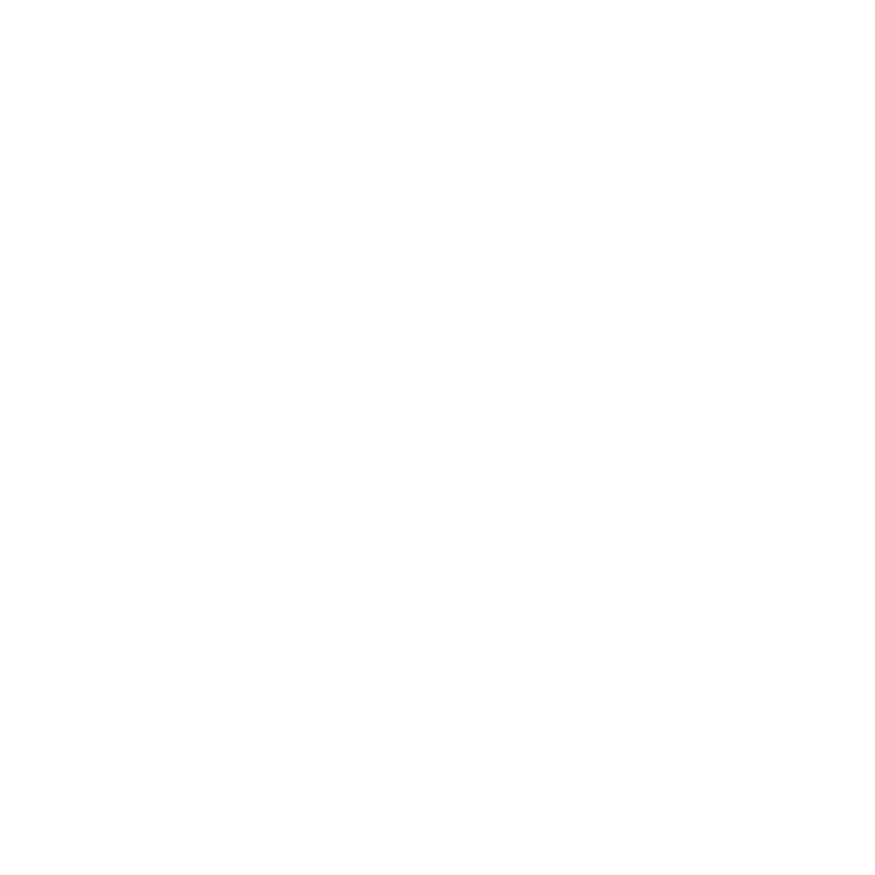

InvalidIndexError: (array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True, False]), 0)

In [63]:
plt.figure(figsize=(7, 7))

colors = ["#FF8C00", "#006400", "#FF1493", "#4169E1"]
markers = ["o", "o", "o", "o"]

for k, col in zip(range(n_clusters2_), colors):
    my_members = cluster_labels2 == k
    cluster_center2 = cluster_centers2[k]
    plt.plot(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df[my_members, 0], 
             MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center2[0],
        cluster_center2[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=10,
    )
plt.title("MeanShift (Density-Based) Clustering of Genotypes by \nPhenotype Measures and DA-Related Neuron Gene Expression Levels \n")
plt.text(-1.5, -0.367, '(Estimated number of clusters: %d)' % n_clusters1_, fontsize=10, color='black', ha='center', weight="bold")
plt.savefig('MergedDARelatedNeurons_meanshiftclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")

plt.show()

### 3B - Hierarchical clustering

#### For Dopaminergic Neurons

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib notebook

# Perform agglomerative clustering, testing different linkage methods
complete_clustering = linkage(MergedDopaminergicNeurons_scaled_df, method="complete", metric="euclidean")
average_clustering = linkage(MergedDopaminergicNeurons_scaled_df, method="average", metric="euclidean")
single_clustering = linkage(MergedDopaminergicNeurons_scaled_df, method="single", metric="euclidean")
ward_clustering = linkage(MergedDopaminergicNeurons_scaled_df, method='ward')

In [ ]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(complete_clustering, orientation = 'top',
          labels=MergedDopaminergicNeurons_scaled_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Complete Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and Dopaminergic Neuron Gene Expression Levels', fontsize = 12)
plt.savefig('MergedDopaminergicNeurons_completehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()


In [ ]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(average_clustering, orientation = 'top',
          labels=MergedDopaminergicNeurons_scaled_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Average Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and Dopaminergic Neuron Gene Expression Levels', fontsize = 12)
plt.savefig('MergedDopaminergicNeurons_averagehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(single_clustering, orientation = 'top',
          labels=MergedDopaminergicNeurons_scaled_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Single Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and Dopaminergic Neuron Gene Expression Levels', fontsize = 12)
plt.savefig('MergedDopaminergicNeurons_singlehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(ward_clustering, orientation = 'top',
          labels=MergedDopaminergicNeurons_scaled_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Ward\'s Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and Dopaminergic Neuron Gene Expression Levels', fontsize = 12)
plt.savefig('MergedDopaminergicNeurons_wardhierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

#### For DA Receptor-Expressing Neurons

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib notebook

# Perform agglomerative clustering, testing different linkage methods
complete_clustering1 = linkage(MergedDAReceptorNeurons_scaled_df, method="complete", metric="euclidean")
average_clustering1 = linkage(MergedDAReceptorNeurons_scaled_df, method="average", metric="euclidean")
single_clustering1 = linkage(MergedDAReceptorNeurons_scaled_df, method="single", metric="euclidean")
ward_clustering1 = linkage(MergedDAReceptorNeurons_scaled_df, method='ward')

In [ ]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(complete_clustering1, orientation = 'top',
          labels=MergedDAReceptorNeurons_scaled_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Complete Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and DA Receptor-Expressing Neuron Gene Expression Levels', fontsize = 11)
plt.savefig('MergedDAReceptorNeurons_completehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(average_clustering1, orientation = 'top',
          labels=MergedDAReceptorNeurons_scaled_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Average Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and DA Receptor-Expressing Neuron Gene Expression Levels', fontsize = 11)
plt.savefig('MergedDAReceptorNeurons_averagehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(single_clustering1, orientation = 'top',
          labels=MergedDAReceptorNeurons_scaled_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Single Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and DA Receptor-Expressing Neuron Gene Expression Levels', fontsize = 11)
plt.savefig('MergedDAReceptorNeurons_singlehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(ward_clustering1, orientation = 'top',
          labels=MergedDAReceptorNeurons_scaled_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Ward\'s Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and DA Receptor-Expressing Neuron Gene Expression Levels', fontsize = 11)
plt.savefig('MergedDAReceptorNeurons_wardhierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

#### For DA-Related Neurons

In [53]:
from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib notebook

MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.set_index('Genotype', inplace=True)

# Perform agglomerative clustering, testing different linkage methods
complete_clustering2 = linkage(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df, method="complete", metric="euclidean")
average_clustering2 = linkage(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df, method="average", metric="euclidean")
single_clustering2 = linkage(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df, method="single", metric="euclidean")
ward_clustering2 = linkage(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df, method='ward')

<IPython.core.display.Javascript object>


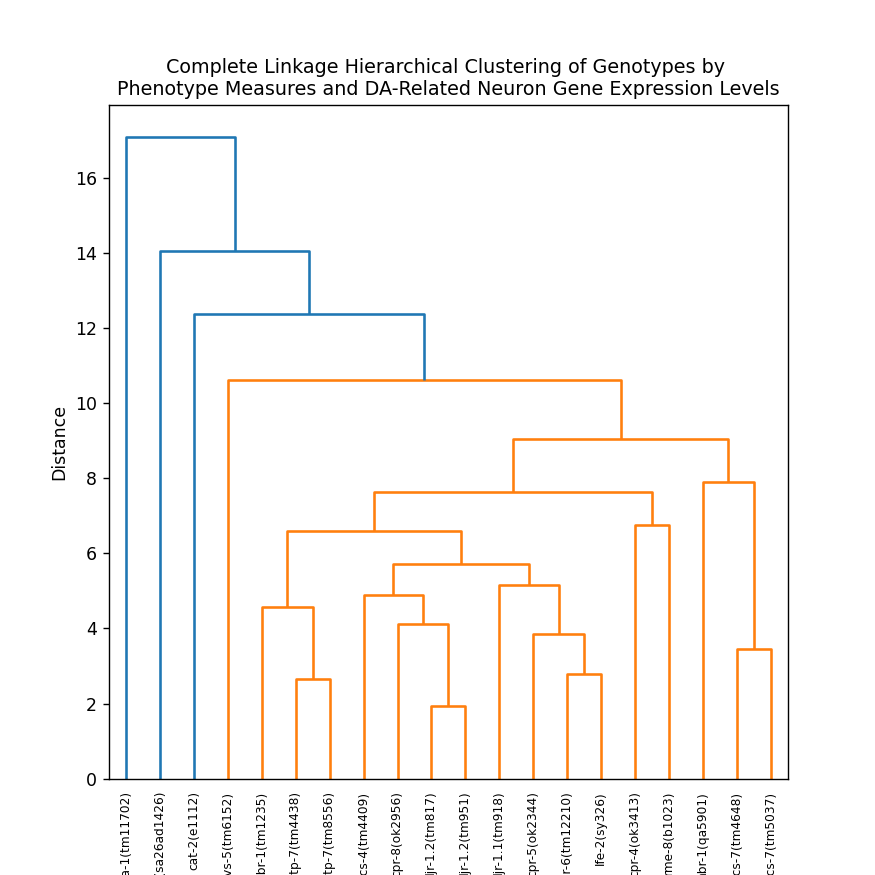

In [54]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(complete_clustering2, orientation = 'top',
          labels=MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Complete Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and DA-Related Neuron Gene Expression Levels', fontsize = 11)
plt.savefig('MergedDARelatedNeurons_completehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

<IPython.core.display.Javascript object>


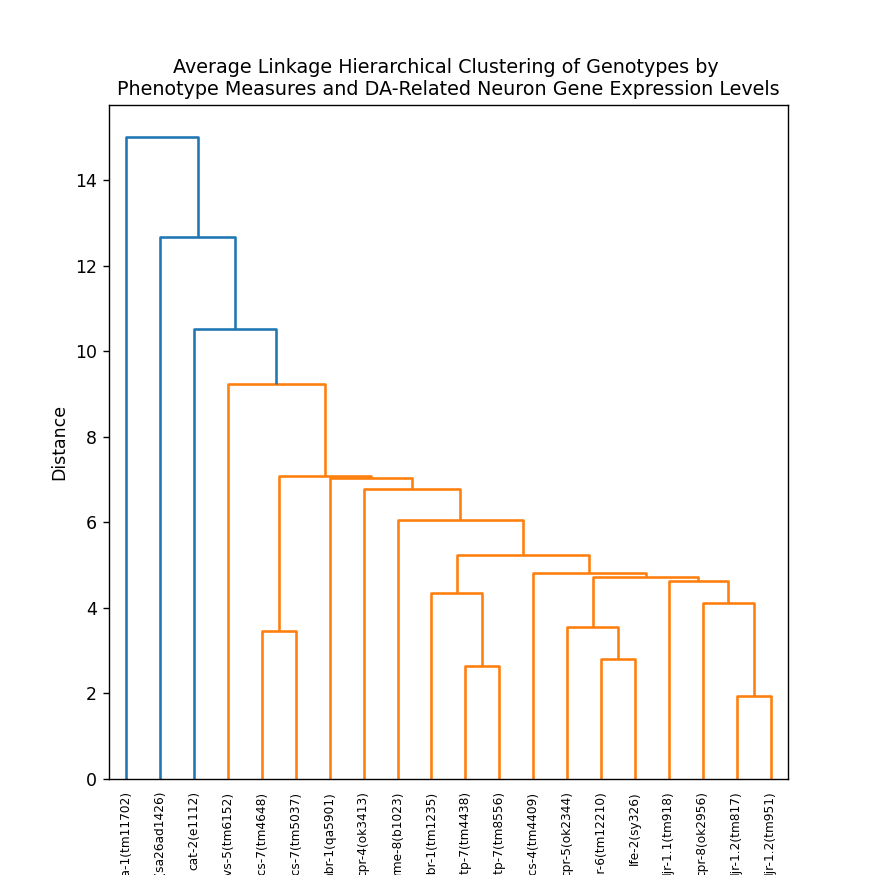

In [55]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(average_clustering2, orientation = 'top',
          labels=MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Average Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and DA-Related Neuron Gene Expression Levels', fontsize = 11)
plt.savefig('MergedDARelatedNeurons_averagehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

<IPython.core.display.Javascript object>


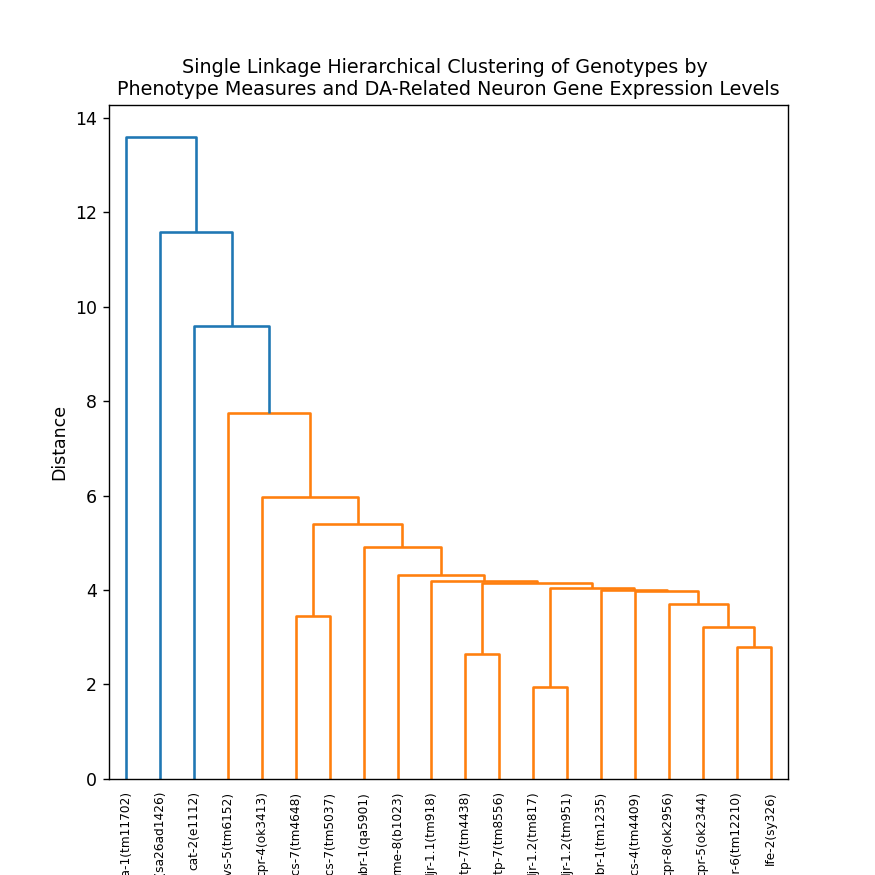

In [56]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(single_clustering2, orientation = 'top',
          labels=MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Single Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and DA-Related Neuron Gene Expression Levels', fontsize = 11)
plt.savefig('MergedDARelatedNeurons_singlehierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

<IPython.core.display.Javascript object>


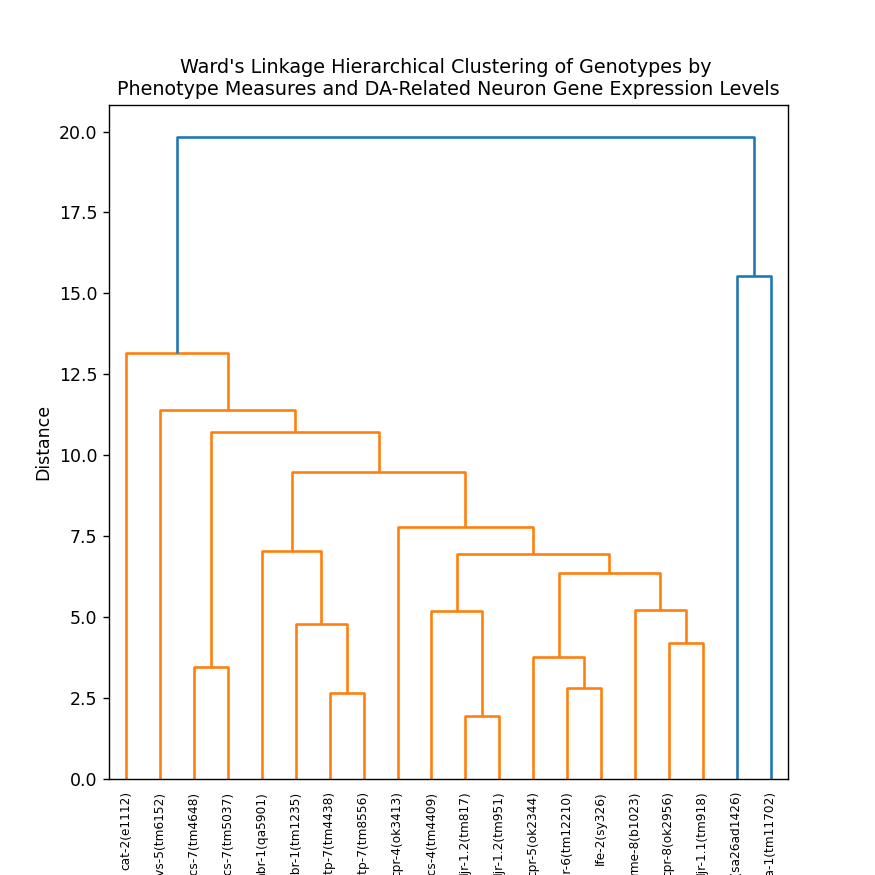

In [57]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
dendrogram(ward_clustering2, orientation = 'top',
          labels=MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.index)
plt.xticks(rotation=90, fontsize = 7)
plt.xlabel('Genotype')
plt.ylabel('Distance')
plt.title('Ward\'s Linkage Hierarchical Clustering of Genotypes by \nPhenotype Measures and DA-Related Neuron Gene Expression Levels', fontsize = 11)
plt.savefig('MergedDARelatedNeurons_wardhierarchicalclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

## 4. Dimensionality reduction (feature extraction) using UMAP


In [ ]:
MergedDopaminergicNeurons_scaled_CorrelationAndVarThresholdFiltered_df = pd.read_csv('MergedDopaminergicNeurons_scaled_CorrelationAndVarThresholdFiltered_df.csv')
MergedDopaminergicNeurons_scaled_CorrelationAndVarThresholdFiltered_minus_Genotype_df = MergedDopaminergicNeurons_scaled_CorrelationAndVarThresholdFiltered_df.drop(columns=['Genotype'])

clusterable_embedding1 = umap.UMAP(
    n_neighbors=5, # default value; larger n_neighbors number is better for the purposes of dimension reduction
    min_dist=0.0,
    n_components=2, # embedding will be projected on a 2-dimensional space for visualization purposes
    random_state=42, #set.seed
).fit_transform(MergedDopaminergicNeurons_scaled_CorrelationAndVarThresholdFiltered_minus_Genotype_df)

In [ ]:
MergedDAReceptorNeurons_scaled_CorrelationAndVarThresholdFiltered_df = pd.read_csv('MergedDAReceptorNeurons_scaled_CorrelationAndVarThresholdFiltered_df.csv')
MergedDAReceptorNeurons_scaled_CorrelationAndVarThresholdFiltered_minus_Genotype_df = MergedDAReceptorNeurons_scaled_CorrelationAndVarThresholdFiltered_df.drop(columns=['Genotype'])

clusterable_embedding2 = umap.UMAP(
    n_neighbors=5, # default value; larger n_neighbors number is better for the purposes of dimension reduction
    min_dist=0.0,
    n_components=2, # embedding will be projected on a 2-dimensional space for visualization purposes
    random_state=42, #set.seed
).fit_transform(MergedDAReceptorNeurons_scaled_CorrelationAndVarThresholdFiltered_minus_Genotype_df)

In [41]:
MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df = pd.read_csv('MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.csv')
MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_minus_Genotype_df = MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.drop(columns=['Genotype'])

clusterable_embedding3 = umap.UMAP(
    n_neighbors=5, # default value; larger n_neighbors number is better for the purposes of dimension reduction
    min_dist=0.0,
    n_components=2, # embedding will be projected on a 2-dimensional space for visualization purposes
    random_state=42, #set.seed
).fit_transform(MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_minus_Genotype_df)

C:\Users\chris\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


#### MeanShift clustering (post-UMAP) for DA-Related Neurons

In [42]:
from sklearn.cluster import MeanShift

# Instantiate MeanShift clustering
meanshift3 = MeanShift()

# Fit MeanShift clustering to the UMAP-transformed data
meanshift3.fit(clusterable_embedding3)

# Get the labels assigned by MeanShift clustering
cluster_labels3 = meanshift3.labels_
cluster_centers3 = meanshift3.cluster_centers_

cluster_labels3_unique = np.unique(cluster_labels3)
n_clusters3_ = len(cluster_labels3_unique)

print("number of estimated clusters : %d" % n_clusters3_)

# Add the genotype information back to the data points
ClusteredMergedDARelatedNeurons_df = MergedDARelatedNeurons_scaled_CorrelationAndVarThresholdFiltered_df.copy()
ClusteredMergedDARelatedNeurons_df['Cluster'] = cluster_labels3
ClusteredMergedDARelatedNeurons_df = ClusteredMergedDARelatedNeurons_df.sort_values(by='Cluster')

ClusteredMergedDARelatedNeurons_df.to_csv('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data\\ClusteredMergedDARelatedNeurons_df.csv', index=True)
print(ClusteredMergedDARelatedNeurons_df)
# Now data_with_genotype contains the genotype column along with the cluster labels assigned by MeanShift clustering

number of estimated clusters : 3
             Genotype    length     width  morphwidth  speed_OffFood  \
3       cpr-4(ok3413) -1.043421  0.178374   -0.561902      -1.265516   
4       cpr-5(ok2344) -1.987510  0.602425   -0.311877      -0.698029   
7      djr-1.1(tm918) -1.296926 -1.824455   -2.192671      -0.190963   
18       rme-8(b1023) -1.530646 -0.078402   -0.955913      -1.910449   
10  exp-2(sa26ad1426) -0.005512  0.837575    1.317394      -0.531920   
12       lfe-2(sy326) -0.902923 -0.837892    0.133356       0.264123   
0        cat-2(e1112)  0.718449  2.375258    1.904257       1.854562   
1      catp-7(tm4438)  0.574900  0.133460   -0.247274       0.725809   
17      ncs-7(tm5037)  1.064180  0.865958    0.939107       1.307165   
5      cpr-6(tm12210)  0.490864  0.206908    0.297867       1.223103   
16      ncs-7(tm4648)  1.658877 -0.234523    0.511519      -0.056646   
15      ncs-4(tm4409)  1.125159 -0.251263   -0.200869      -0.548028   
14      mbr-1(tm1235)  0.583574

### Post-UMAP MeanShift clustering visualization


<IPython.core.display.Javascript object>


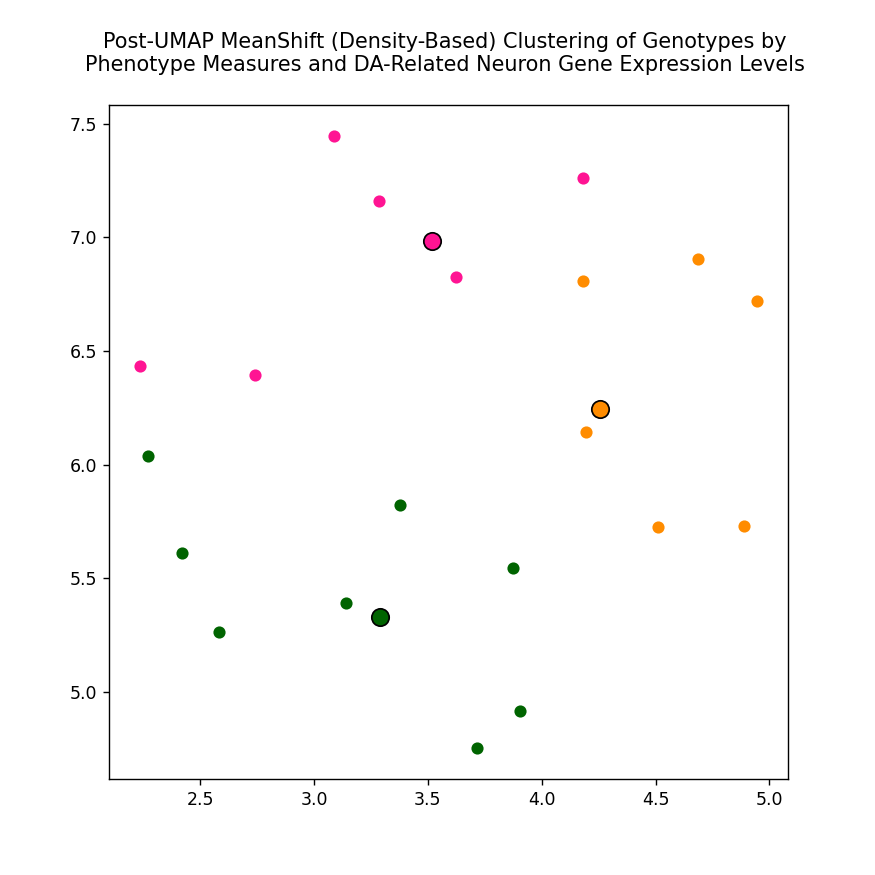

In [64]:
plt.figure(figsize=(7, 7))

colors = ["#FF8C00", "#006400", "#FF1493", "#4169E1"]
markers = ["o", "o", "o", "o"]

for k, col in zip(range(n_clusters3_), colors):
    my_members = cluster_labels3 == k
    cluster_center3 = cluster_centers3[k]
    plt.plot(clusterable_embedding3[my_members, 0], clusterable_embedding3[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center3[0],
        cluster_center3[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=10,
    )
plt.title("Post-UMAP MeanShift (Density-Based) Clustering of Genotypes by \nPhenotype Measures and DA-Related Neuron Gene Expression Levels \n")
plt.text(-1.5, -0.367, '(Estimated number of clusters: %d)' % n_clusters3_, fontsize=10, color='black', ha='center', weight="bold")
plt.savefig('MergedDARelatedNeurons_UMAPmeanshiftclustering.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")

plt.show()